/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_46224/1228651464.py:105: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),


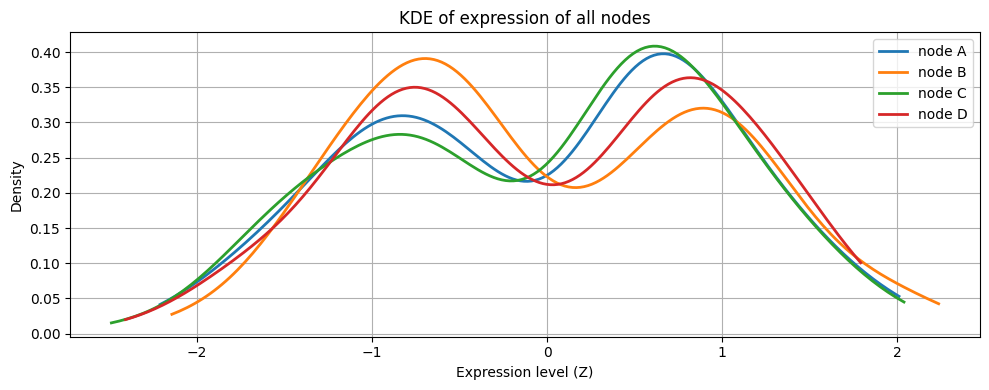

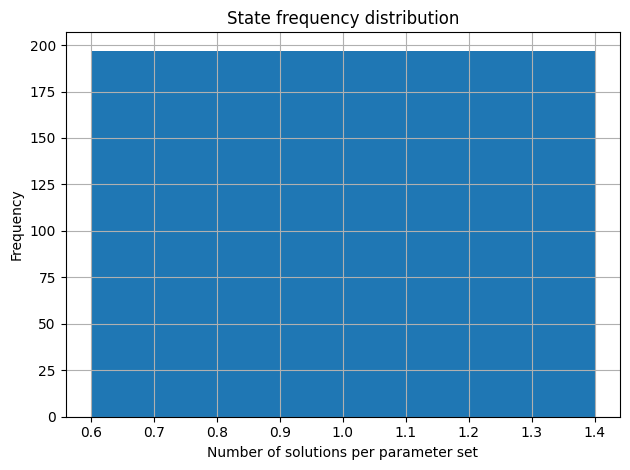

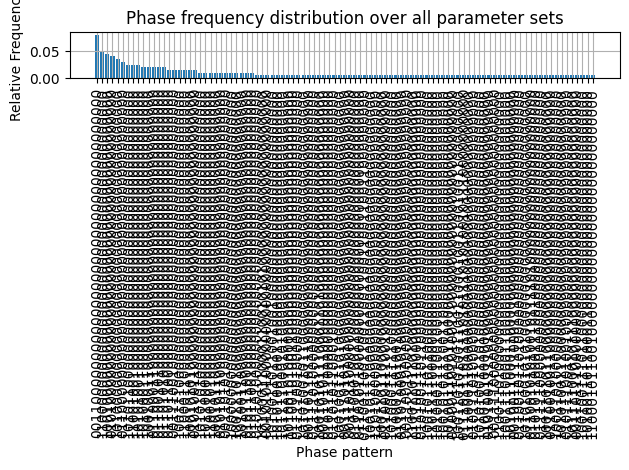

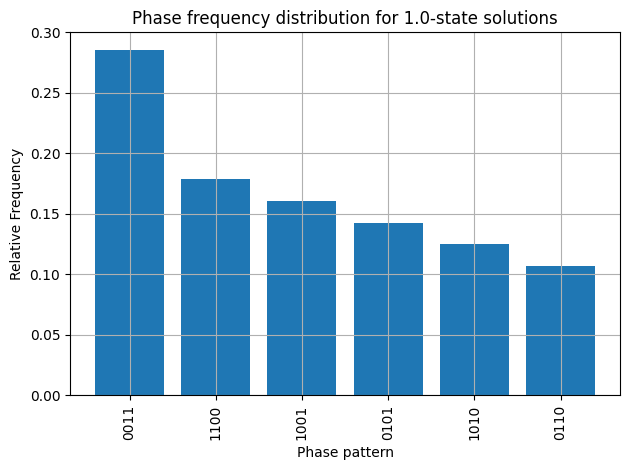

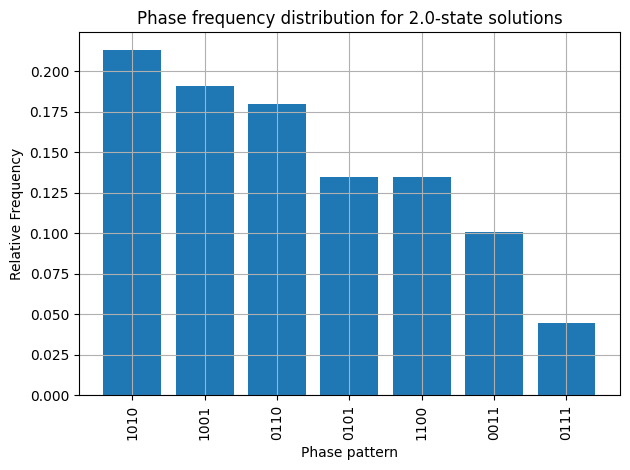

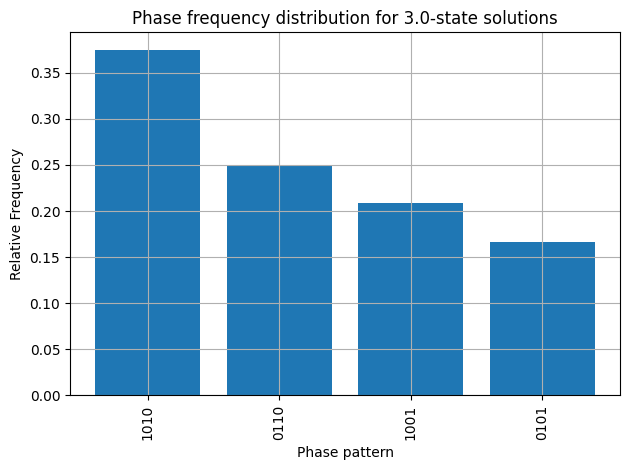

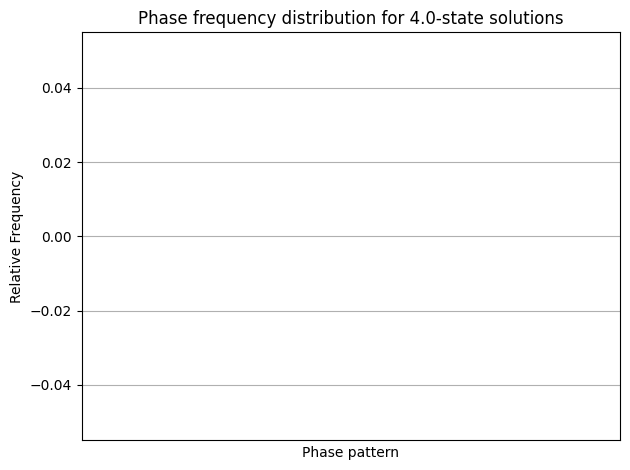

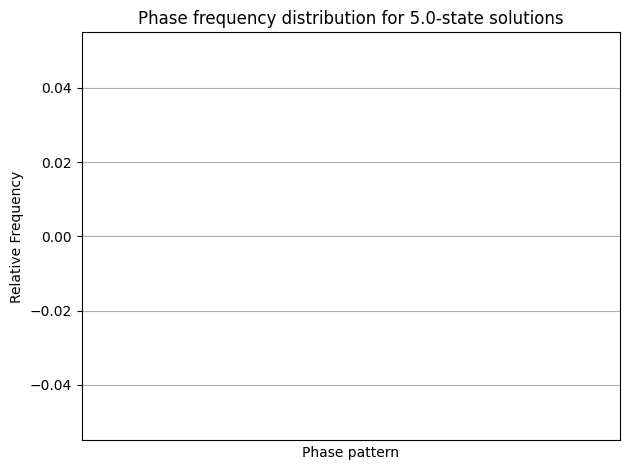

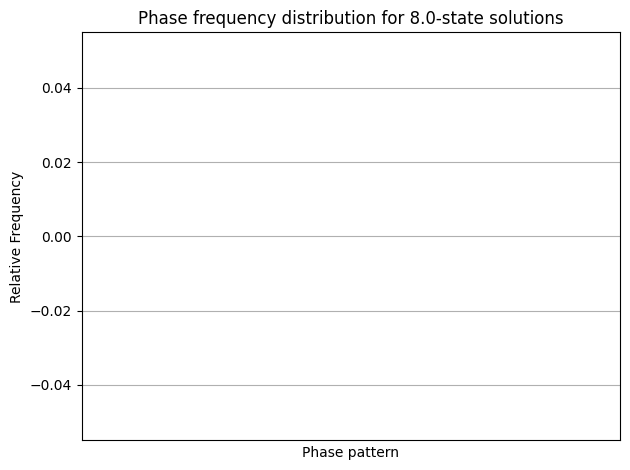

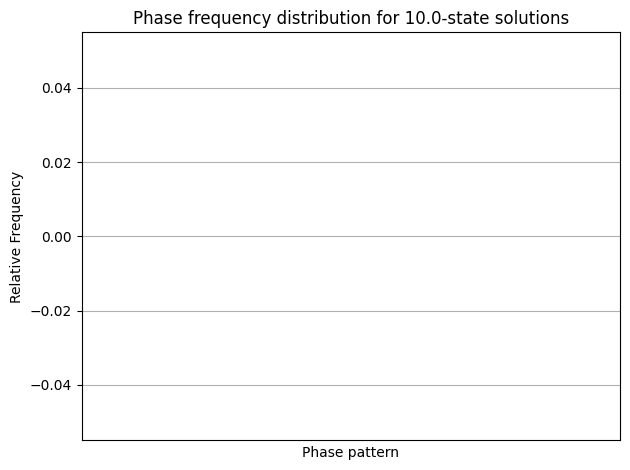

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# ——————————————————————————————————————————————————————————————————————————————
# Functions mirroring the MATLAB script
# ——————————————————————————————————————————————————————————————————————————————

def Z_normalizing(df):
    dfn = df.copy().astype(float)
    means = dfn.iloc[:,2:].mean(axis=0)
    stds  = dfn.iloc[:,2:].std(axis=0)
    dfn.iloc[:,2:] = (dfn.iloc[:,2:] - means) / stds
    return dfn

def state_count(dfb):
    counts = dfb.groupby([0,1]).size()
    freq   = counts.value_counts().sort_index()
    M      = counts.max()
    return [int(freq.get(i,0)) for i in range(1, M+1)]

def phase_changer(df, thresholds):
    dfb = df.copy().astype(float)
    n_thr = len(thresholds)
    for col in range(2, dfb.shape[1]):
        th = thresholds[(col-2) % n_thr]
        dfb.iloc[:,col] = (dfb.iloc[:,col] > th).astype(int)
    return dfb

def phase_counter(dfb):
    pats = dfb.iloc[:,2:].astype(int).astype(str).agg(''.join, axis=1)
    freq = pats.value_counts()
    return freq.index.tolist(), freq.values.tolist()

def state_divider(dfb):
    # cast states to int so keys are ints
    dfb.iloc[:,1] = dfb.iloc[:,1].astype(int)
    return {s: dfb[dfb.iloc[:,1] == s]
            for s in sorted(dfb.iloc[:,1].unique())}

from collections import Counter

def phase_counting_and_arrangement_for_all_states(divided, n_nodes=4):
    """
    For each multistability case:
      • for each parameter set (grouped by column 0), take its ns rows
        of boolean data (columns 2…2+n_nodes), flatten into a single
        vector of length ns*n_nodes, and record that pattern.
      • count frequencies of these patterns across all parameter sets.
    """
    ia = {}
    phase_order = {}
    phase_freq  = {}
    all_phases  = {}
    organized   = {}

    for ns, df_sub in divided.items():
        patterns = []
        organized_list = []
        # group by parameter index (column 0)
        for param_idx, group in df_sub.groupby(0):
            # group has exactly ns rows
            # take only the first n_nodes columns of each row
            bool_mat = group.iloc[:, 2:2 + n_nodes].to_numpy(dtype=int)
            flat = bool_mat.flatten()
            pat = ''.join(map(str, flat))
            patterns.append(pat)
            organized_list.append(flat)

        # count pattern frequencies
        freq_counter = Counter(patterns)
        freq_items = freq_counter.most_common()  # list of (pattern, count)

        # unpack into parallel lists
        pats, freqs = zip(*freq_items) if freq_items else ([], [])
        
        ia[ns]          = None
        phase_order[ns] = None
        phase_freq[ns]  = list(freqs)
        all_phases[ns]  = list(pats)
        organized[ns]   = np.vstack(organized_list) if organized_list else np.empty((0, ns*n_nodes), int)

    return ia, phase_order, phase_freq, all_phases, organized


# ——————————————————————————————————————————————————————————————————————————————
# Main analysis
# ——————————————————————————————————————————————————————————————————————————————

pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/RACIPE-1.0/"   # update to your actual path

# 1) read variable-length solutions
data = []
with open("/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/RACIPE_custom_ss_noepigenetic.dat") as f:
    for L in f:
        data.append([float(x) for x in L.split()])
maxlen = max(len(r) for r in data)
for r in data:
    r += [np.nan]*(maxlen-len(r))
sol = pd.DataFrame(data)

# 2) read parameters + names
pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),
                   delim_whitespace=True, header=None)
prs_names = [ln.strip() for ln in open(os.path.join(pt,"TTr.txt")) if ln.strip()]
npars = pars.shape[1]-2
prs_names = (prs_names + [f"param{i}" for i in range(1,npars+1)])[:npars]
pars.columns = ["S_no","States_number"] + prs_names

# 3) normalize, filter, booleanize
sol_z    = Z_normalizing(sol)
sol_z    = sol_z[sol_z.iloc[:,1] < 17]
bool_sol = phase_changer(sol_z, [0,0,0,0])
# ensure states_number column is int
bool_sol.iloc[:,1] = bool_sol.iloc[:,1].astype(int)

# 4) frequencies
state_freq         = state_count(bool_sol)
all_phases, all_freq = phase_counter(bool_sol)
divided            = state_divider(bool_sol)
ia, phase_order, phase_freq, phases, organized = \
    phase_counting_and_arrangement_for_all_states(divided)

# ——————————————————————————————————————————————————————————————————————————————
# 6) Plotting
# A) KDE of nodes A–D
plt.figure(figsize=(10,4))
labels = ["node A","node B","node C","node D"]
for i,lbl in enumerate(labels):
    vals = sol_z.iloc[:,2+i].dropna().values
    kde  = gaussian_kde(vals)
    xi   = np.linspace(vals.min(), vals.max(), 200)
    plt.plot(xi, kde(xi), lw=2, label=lbl)
plt.title("KDE of expression of all nodes")
plt.xlabel("Expression level (Z)")
plt.ylabel("Density")
plt.legend()
plt.grid(True,which='both')
plt.tight_layout()
plt.show()

# B) State-frequency
plt.figure()
plt.bar(range(1,len(state_freq)+1), state_freq)
plt.title("State frequency distribution")
plt.xlabel("Number of solutions per parameter set")
plt.ylabel("Frequency")
plt.grid(True,which='both')
plt.tight_layout()
plt.show()

# C) Overall phase-frequency
rel = np.array(all_freq)/sum(all_freq)
plt.figure()
plt.bar(all_phases, rel)
plt.title("Phase frequency distribution over all parameter sets")
plt.xlabel("Phase pattern")
plt.ylabel("Relative Frequency")
plt.xticks(rotation=90)
plt.grid(True,which='both')
plt.tight_layout()
plt.show()

# D) Per‐multistability phase-frequency
for ns,pats in phases.items():
    freqs = phase_freq[ns]
    mask  = np.array(freqs)>3
    pf    = np.array(pats)[mask]
    rf    = np.array(freqs)[mask]/sum(np.array(freqs)[mask])
    plt.figure()
    plt.bar(pf, rf)
    plt.title(f"Phase frequency distribution for {ns}-state solutions")
    plt.xlabel("Phase pattern")
    plt.ylabel("Relative Frequency")
    plt.xticks(rotation=90)
    plt.grid(True,which='both')
    plt.tight_layout()
    plt.show()


In [ ]:
'''/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/RACIPE-1.0/'''

/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_82649/1382373201.py:103: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(os.path.join(pt, "TS_parameters.dat"),


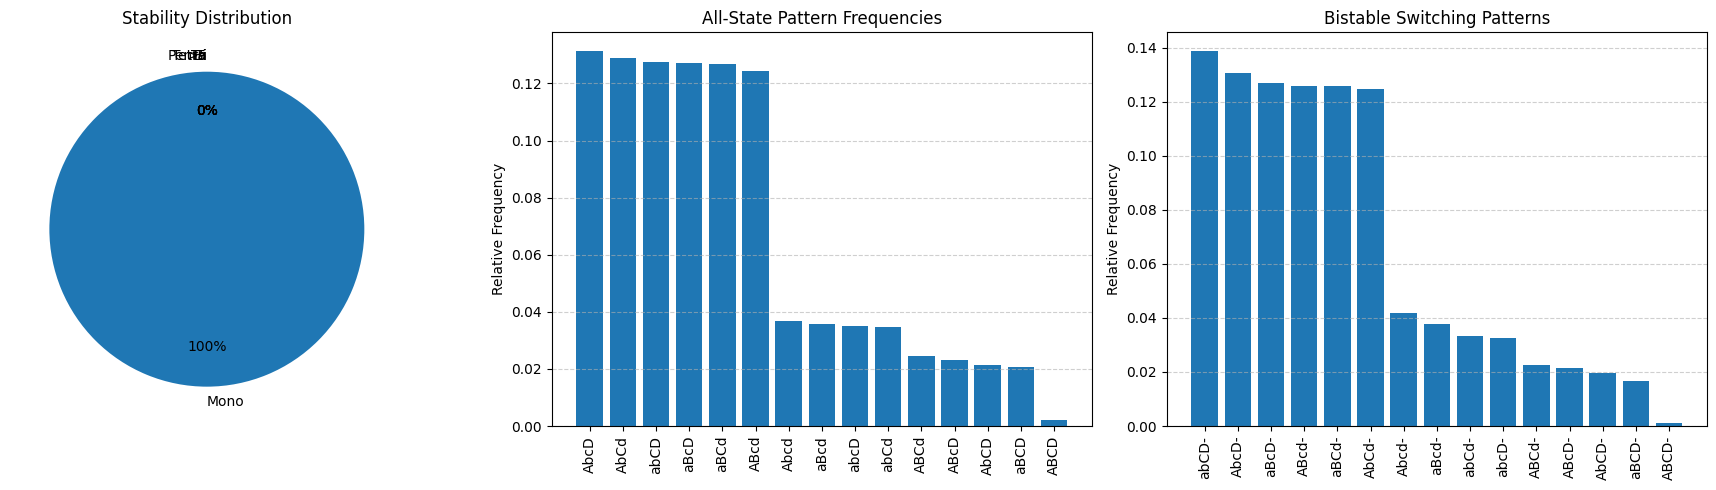

In [15]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from collections import Counter

# ——————————————————————————————————————————————————————————————————————————————
# Helper functions
# ——————————————————————————————————————————————————————————————————————————————

def Z_normalizing(df):
    """Z-score normalize columns 2…end."""
    dfn = df.copy().astype(float)
    means = dfn.iloc[:,2:].mean(axis=0)
    stds  = dfn.iloc[:,2:].std(axis=0)
    dfn.iloc[:,2:] = (dfn.iloc[:,2:] - means) / stds
    return dfn

def state_count(dfb):
    """Return list where index i = number of param‐sets with (i+1) solutions."""
    counts = dfb.groupby([0,1]).size()
    freq   = counts.value_counts().sort_index()
    M      = counts.max()
    return [int(freq.get(i,0)) for i in range(1, M+1)]

def phase_changer(df, thresholds):
    """Booleanize cols 2…end, cycling through thresholds per node."""
    dfb = df.copy().astype(float)
    n_thr = len(thresholds)
    for col in range(2, dfb.shape[1]):
        thr = thresholds[(col-2) % n_thr]
        dfb.iloc[:,col] = (dfb.iloc[:,col] > thr).astype(int)
    return dfb

def phase_counter(dfb):
    """Concat each row's bool pattern of cols 2…end, count frequencies."""
    pats = dfb.iloc[:,2:].astype(int).astype(str).agg(''.join, axis=1)
    freq = pats.value_counts()
    return freq.index.tolist(), freq.values.tolist()

def state_divider(dfb):
    """Split dfb into dict keyed by number_of_states (col 1)."""
    dfb = dfb.copy()
    dfb.iloc[:,1] = dfb.iloc[:,1].astype(int)
    return {s: dfb[dfb.iloc[:,1]==s] for s in sorted(dfb.iloc[:,1].unique())}

def phase_counting_and_arrangement_for_all_states(divd, n_nodes=4):
    """
    For each multistability case ns:
      group by param-index (col 0), flatten ns×n_nodes bools,
      count unique patterns.
    """
    phase_freq = {}
    phases     = {}
    organized  = {}
    for ns, sub in divd.items():
        patterns = []
        mats = []
        for _, group in sub.groupby(0):
            # group: ns rows, bool cols start at idx 2
            mat = group.iloc[:,2:2+n_nodes].to_numpy(dtype=int)
            flat = mat.flatten()
            patterns.append(''.join(map(str, flat)))
            mats.append(flat)
        cnt = Counter(patterns)
        items = cnt.most_common()
        if items:
            pats, freqs = zip(*items)
        else:
            pats, freqs = [], []
        phase_freq[int(ns)] = list(freqs)
        phases[int(ns)]     = list(pats)
        organized[int(ns)]  = np.vstack(mats) if mats else np.empty((0, ns*n_nodes),int)
    return phase_freq, phases, organized

def bits_to_name(bits):
    """Convert bit string '1010' to 'AbCd' notation."""
    letters = ['A','B','C','D']
    return ''.join(
        letters[i] if bits[i]=='1' else letters[i].lower()
        for i in range(len(bits))
    )

# ——————————————————————————————————————————————————————————————————————————————
# Main analysis
# ——————————————————————————————————————————————————————————————————————————————

# 1. Set path to your data folder
pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/RACIPE-1.0/"

# 2. Read combined_solutions.dat (variable columns)
data = []
with open(os.path.join(pt, "combined_solutions.dat"), 'r') as f:
    for line in f:
        data.append([float(x) for x in line.split()])
maxlen = max(len(r) for r in data)
for r in data:
    r.extend([np.nan]*(maxlen - len(r)))
sol = pd.DataFrame(data)

# 3. Read parameters and names (not used for plots here)
pars = pd.read_csv(os.path.join(pt, "TS_parameters.dat"),
                   delim_whitespace=True, header=None)
prs_names = [ln.strip() for ln in open(os.path.join(pt, "TTr.txt")) if ln.strip()]
npars = pars.shape[1] - 2
prs_names = (prs_names + [f"param{i}" for i in range(1,npars+1)])[:npars]
pars.columns = ["S_no","States_number"] + prs_names

# 4. Normalize, filter (>17), booleanize
sol_z    = Z_normalizing(sol)
sol_z    = sol_z[sol_z.iloc[:,1] < 17]
bool_sol = phase_changer(sol_z, [0,0,0,0])
bool_sol.iloc[:,1] = bool_sol.iloc[:,1].astype(int)

# 5. Compute frequencies
state_freq         = state_count(bool_sol)
all_phases, all_freq = phase_counter(bool_sol)
divided            = state_divider(bool_sol)
phase_freq, phases, organized = phase_counting_and_arrangement_for_all_states(divided)

# ——————————————————————————————————————————————————————————————————————————————
# Plotting: 3 panels
# ——————————————————————————————————————————————————————————————————————————————

# A) Pie chart: stability distribution
mono   = state_freq[0] if len(state_freq)>0 else 0
bi     = state_freq[1] if len(state_freq)>1 else 0
tri    = state_freq[2] if len(state_freq)>2 else 0
tetra  = state_freq[3] if len(state_freq)>3 else 0
penta  = state_freq[4] if len(state_freq)>4 else 0
others = sum(state_freq[5:]) if len(state_freq)>5 else 0

pie_labels = ['Mono','Bi','Tri','Tetra','Penta','>5']
pie_sizes  = [mono, bi, tri, tetra, penta, others]

# B) Master bar: all single-state patterns across all solutions
single_patterns = []
for ns, mat in organized.items():
    # mat shape (#params, ns*4)
    flat = mat.reshape(-1, 4)
    single_patterns += [''.join(map(str,row)) for row in flat]
cnt1 = Counter(single_patterns)
items1 = cnt1.most_common()
if items1:
    pats1, cnts1 = zip(*items1)
else:
    pats1, cnts1 = [], []
labels1 = [bits_to_name(p) for p in pats1]
rel1    = np.array(cnts1) / sum(cnts1) if cnts1 else np.array([])

# C) Bistable bar: only ns=2
if 2 in phases:
    pat2s = phases[2]
    cnt2s = phase_freq[2]
    labels2 = [f"{bits_to_name(p[:4])}-{bits_to_name(p[4:])}" for p in pat2s]
    rel2    = np.array(cnt2s) / sum(cnt2s) if cnt2s else np.array([])
else:
    labels2, rel2 = [], []

# Plot
fig, axes = plt.subplots(1,3, figsize=(18,5))

# Pie
axes[0].pie(pie_sizes, labels=pie_labels, autopct='%1.0f%%',
            startangle=90, pctdistance=0.75)
axes[0].set_title('Stability Distribution')

# Master bar
axes[1].bar(labels1, rel1)
axes[1].set_title('All-State Pattern Frequencies')
axes[1].set_ylabel('Relative Frequency')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Bistable bar
axes[2].bar(labels2, rel2)
axes[2].set_title('Bistable Switching Patterns')
axes[2].set_ylabel('Relative Frequency')
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_46224/996873268.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),


1
1.0    26
2.0    49
3.0    13
4.0     8
7.0     1
8.0     1
Name: count, dtype: int64
0     4.0
1     1.0
2     2.0
3     3.0
4     2.0
     ... 
93    2.0
94    4.0
95    2.0
96    3.0
97    1.0
Name: 1, Length: 98, dtype: float64


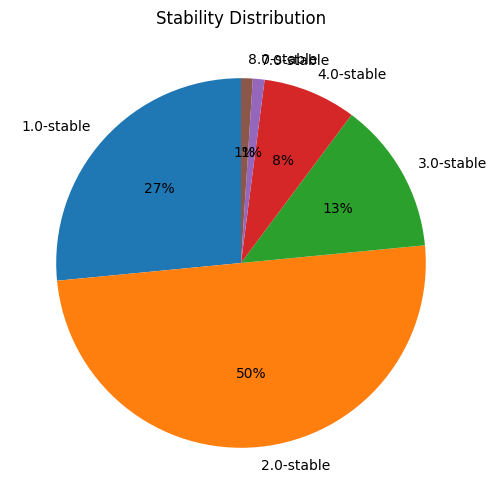

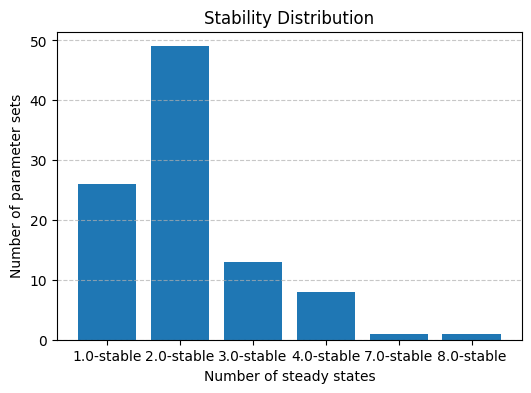

In [9]:
import matplotlib.pyplot as plt

data = []
with open("/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/RACIPE_custom_ss_epigenetic_0.dat") as f:
    for L in f:
        data.append([float(x) for x in L.split()])
maxlen = max(len(r) for r in data)
for r in data:
    r += [np.nan]*(maxlen-len(r))
sol = pd.DataFrame(data)

# 2) read parameters + names
pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),
                   delim_whitespace=True, header=None)
prs_names = [ln.strip() for ln in open(os.path.join(pt,"TTr.txt")) if ln.strip()]
npars = pars.shape[1]-2
prs_names = (prs_names + [f"param{i}" for i in range(1,npars+1)])[:npars]
pars.columns = ["S_no","States_number"] + prs_names

# 3) normalize, filter, booleanize
sol_z    = sol
sol_z    = sol_z[sol_z.iloc[:,1] < 17]

# 1) Frequency of each multistability
stability_counts = sol_z.iloc[:,1].value_counts().sort_index()
print(stability_counts)
print(sol_z.iloc[:,1])
# e.g. stability_counts might be:
#    1    1500
#    2     900
#    3     400
#    4     200
#    5     100
#    6      50
#    dtype: int64

# 2) Pie chart
labels = [f"{i}-stable" for i in stability_counts.index]
sizes  = stability_counts.values
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90)
plt.title("Stability Distribution")
plt.show()

# 3) Bar chart (if you prefer)
plt.figure(figsize=(6,4))
plt.bar(labels, sizes)
plt.xlabel("Number of steady states")
plt.ylabel("Number of parameter sets")
plt.title("Stability Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


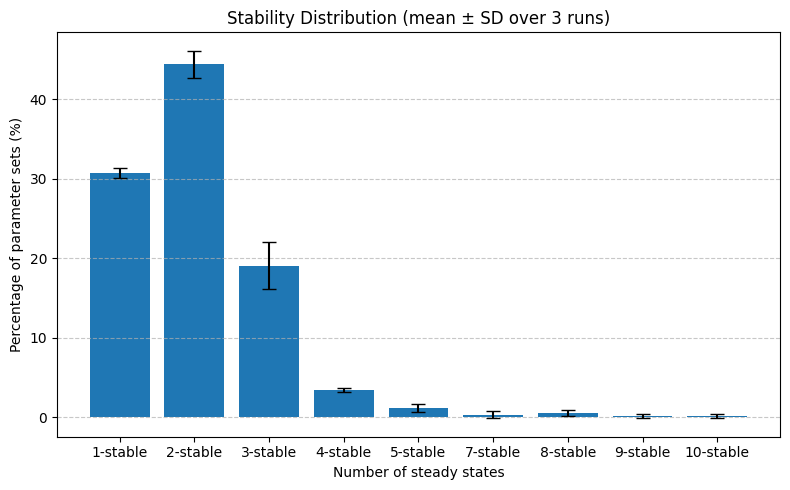

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to folder containing your three output files
pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test"

file_names = [
    "1_random_200_RACIPE_custom_ss_noepigenetic.dat",
    "2_random_200_RACIPE_custom_ss_noepigenetic.dat",
    "3_random_200_RACIPE_custom_ss_noepigenetic.dat"
]

counts_list = []
for fname in file_names:
    # 1) load raw data
    data = []
    with open(os.path.join(pt, fname)) as f:
        for L in f:
            data.append([float(x) for x in L.split()])
    # 2) pad rows to equal length
    maxlen = max(len(r) for r in data)
    for r in data:
        r.extend([np.nan] * (maxlen - len(r)))
    sol = pd.DataFrame(data)
    # 3) filter out >17 states if needed
    sol = sol[sol.iloc[:,1] < 17]
    # 4) count stability
    stability_counts = sol.iloc[:,1].value_counts().sort_index()
    # 5) convert to percentage of sets in this run
    total = stability_counts.sum()
    counts_list.append(stability_counts / total * 100)

# 6) Align state‐numbers across runs
all_states = sorted({ int(s) for c in counts_list for s in c.index })

# 7) Build array (runs × states) of percentages
freqs = np.array([
    [c.get(state, 0.0) for state in all_states]
    for c in counts_list
])

# 8) Compute mean & std (in percentages)
means = freqs.mean(axis=0)
stds  = freqs.std(axis=0)

# 9) Plot bar with error bars (percentage)
labels = [f"{s}-stable" for s in all_states]
x = np.arange(len(all_states))

plt.figure(figsize=(8,5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels)
plt.xlabel("Number of steady states")
plt.ylabel("Percentage of parameter sets (%)")
plt.title("Stability Distribution (mean ± SD over 3 runs)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
